<a href="https://colab.research.google.com/github/AomAmTananya/Project-Predicting-Student-Stress-Level/blob/main/CP462_Project_Predicting_Student_Stress_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CP462 Project:  Predicting Student Stress Level from Lifestyle Behaviors**

# หัวข้อ : **ทำนายความเครียดของนักศึกษาจากพฤติกรรมการใช้ชีวิต**

**Group 1 สมาชิก:**
<br>1) นายคุณานนต์ หฤทัยธรรม (ID: 66102010134)
<br>2) นายณัฐนนท์ หลิมเหล็ก (ID : 66102010137)
<br>3) นางสาวธนัญญา หินทุม (ID : 66102010241)
<br><br>
**Dataset:** student lifestyle dataset <br>
**Source:** https://www.kaggle.com/datasets/steve1215rogg/student-lifestyle-dataset

#Part 1

## **Import Packages**

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
import joblib
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score




## **Import Dataset**

In [ ]:
from google.colab import files
print("โปรดอัปโหลดไฟล์ student_lifestyle_dataset.csv")
uploaded = files.upload()

โปรดอัปโหลดไฟล์ student_lifestyle_dataset.csv


Saving student_lifestyle_dataset.csv to student_lifestyle_dataset.csv


##Data Wrangling

### Grathering

In [ ]:
df = pd.read_csv("student_lifestyle_dataset.csv")

#ดูข้อมูลเบื้องต้น
print("\n=== 5 แถวแรก ===")
display(df.head())
print("\nShape:", df.shape)
display(df.isna().sum().rename("Missing Values"))
print("จำนวนข้อมูลซ้ำ:", df.duplicated().sum(), "\n")


=== 5 แถวแรก ===


,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High



Shape: (2000, 8)


,Missing Values
Student_ID,0
Study_Hours_Per_Day,0
Extracurricular_Hours_Per_Day,0
Sleep_Hours_Per_Day,0
Social_Hours_Per_Day,0
Physical_Activity_Hours_Per_Day,0
GPA,0
Stress_Level,0


จำนวนข้อมูลซ้ำ: 0 



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       2000 non-null   int64  
 1   Study_Hours_Per_Day              2000 non-null   float64
 2   Extracurricular_Hours_Per_Day    2000 non-null   float64
 3   Sleep_Hours_Per_Day              2000 non-null   float64
 4   Social_Hours_Per_Day             2000 non-null   float64
 5   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 6   GPA                              2000 non-null   float64
 7   Stress_Level                     2000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB


### Cleaning

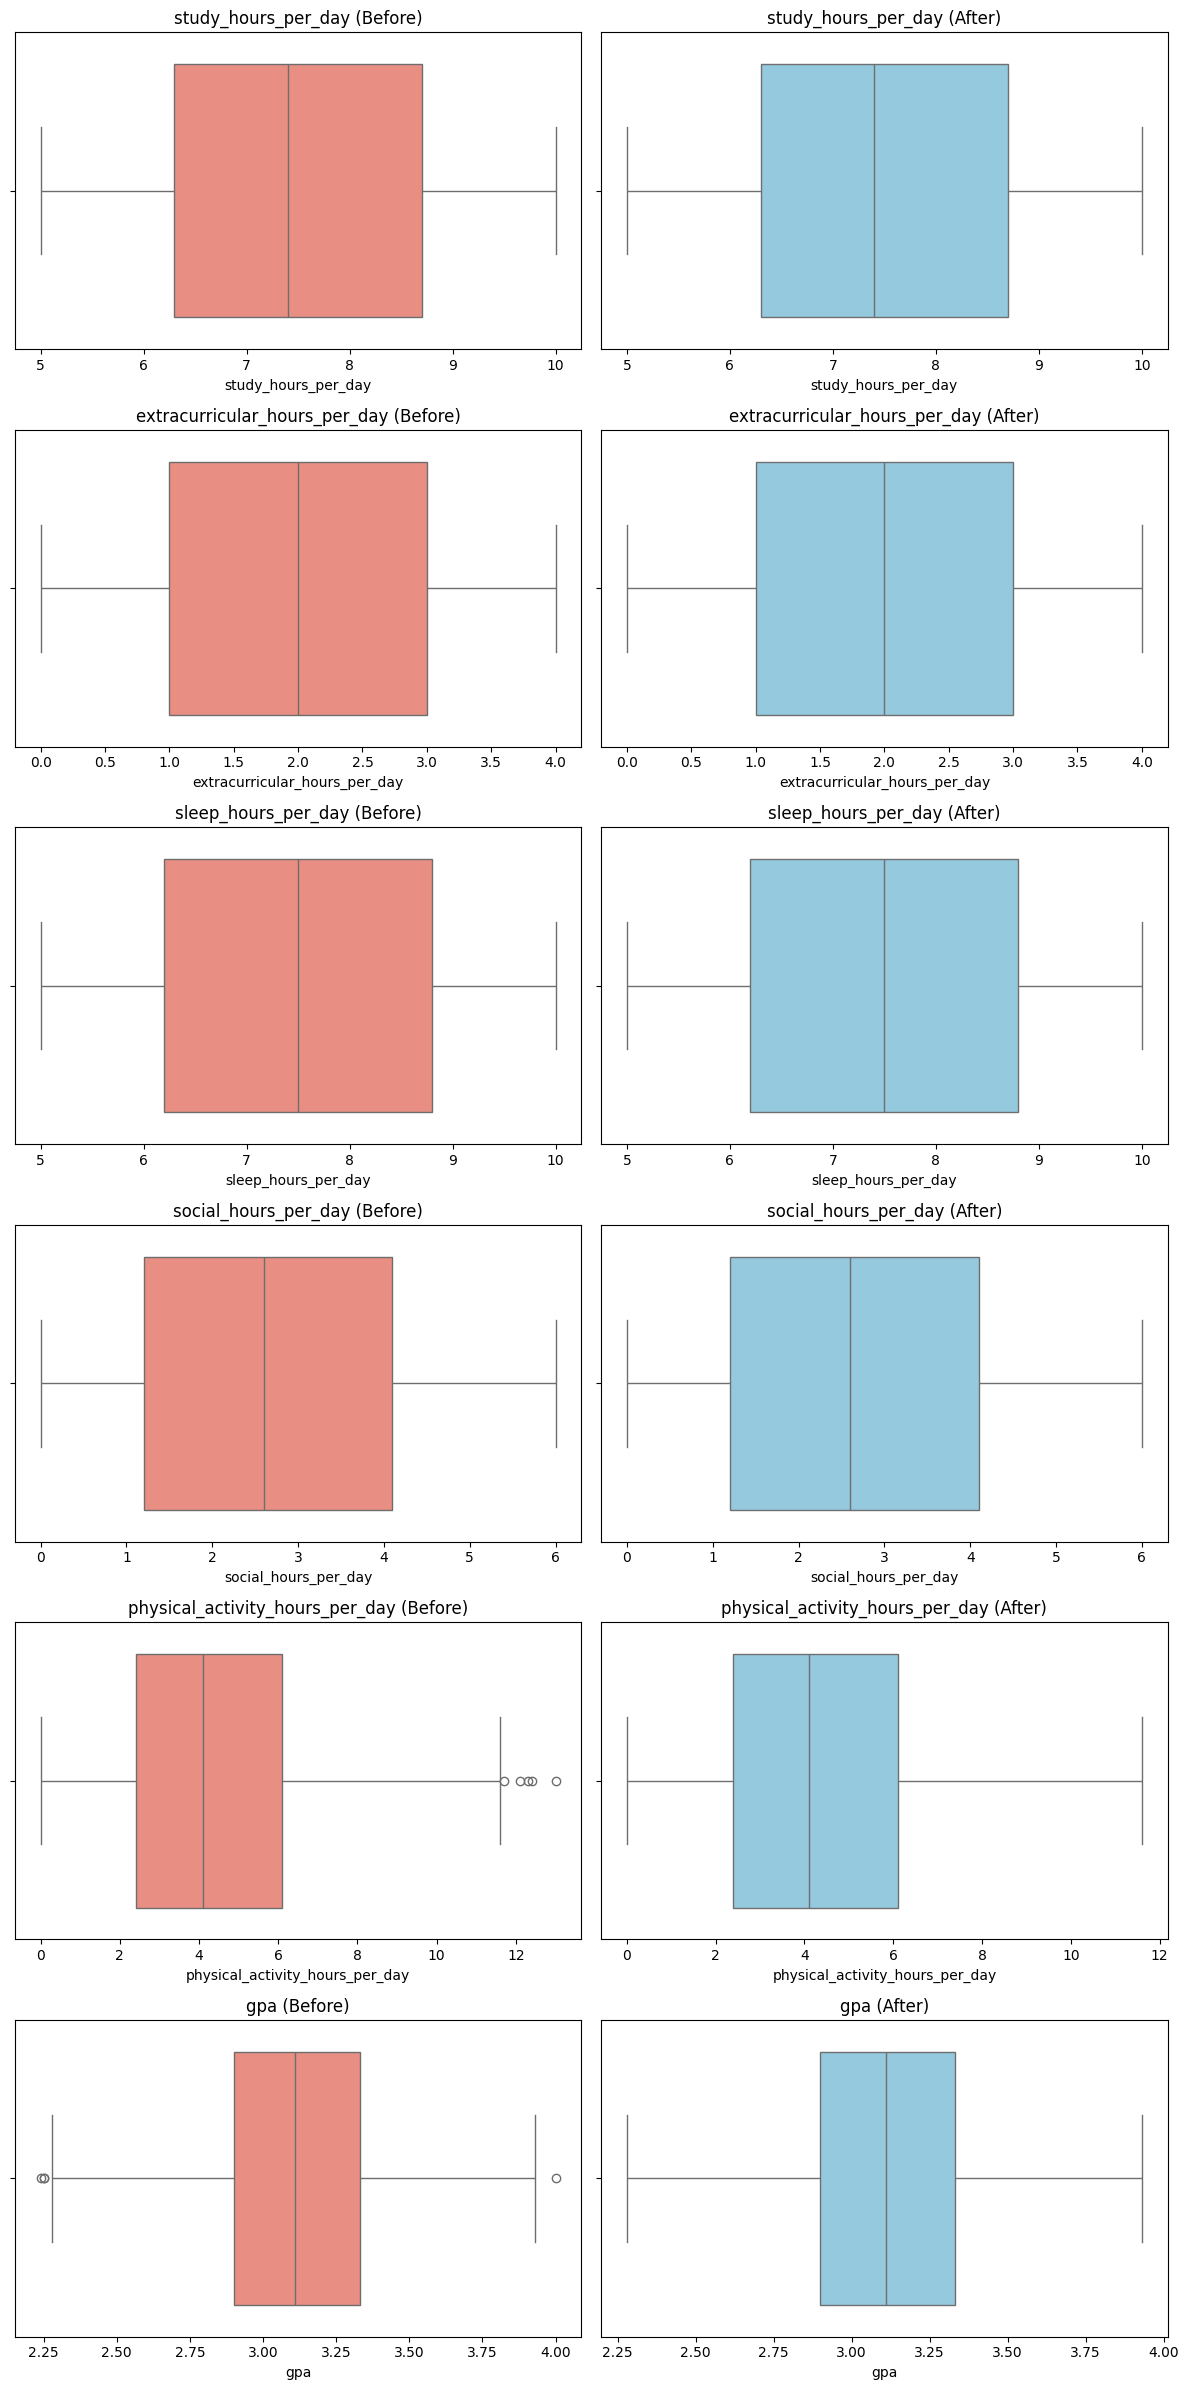

Shape ของ DataFrame หลังลบ outlier: (1991, 7)

Dropped duplicates: 0


In [ ]:
#Clean column names
orig_cols = df.columns.tolist()
new_cols = []
for c in orig_cols:
    nc = c.strip().replace(' ', '_')
    nc = re.sub('[^0-9a-zA-Z_]', '', nc)
    nc = nc.lower()
    new_cols.append(nc)
df.columns = new_cols

# ตรวจสอบว่ามีคอลัมน์ 'student_id' อยู่ก่อนที่จะลบ
if 'student_id' in df.columns:
    df = df.drop(columns=['student_id'])

# คอลัมน์ numeric ที่จะตรวจ outlier
numeric_cols = ['study_hours_per_day', 'extracurricular_hours_per_day',
                'sleep_hours_per_day', 'social_hours_per_day',
                'physical_activity_hours_per_day', 'gpa']

# สร้าง subplot เพื่อเปรียบเทียบ Boxplot ก่อน–หลัง
fig, axes = plt.subplots(nrows=len(numeric_cols), ncols=2, figsize=(12, 4*len(numeric_cols)))

for i, col in enumerate(numeric_cols):
    # Boxplot ก่อนลบ outlier
    sns.boxplot(x=df[col], color="salmon", ax=axes[i,0])
    axes[i,0].set_title(f"{col} (Before)")

    # คำนวณ IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # ลบ outlier **โดยตรงกับ df**
    df = df[(df[col] >= lower) & (df[col] <= upper)]

    # Boxplot หลังลบ outlier
    sns.boxplot(x=df[col], color="skyblue", ax=axes[i,1])
    axes[i,1].set_title(f"{col} (After)")

plt.tight_layout()
plt.show()

print("Shape ของ DataFrame หลังลบ outlier:", df.shape)

#ลบแถวซ้ำ
before = df.shape[0]
df.drop_duplicates(inplace=True)
print("\nDropped duplicates:", before - df.shape[0])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1991 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   study_hours_per_day              1991 non-null   float64
 1   extracurricular_hours_per_day    1991 non-null   float64
 2   sleep_hours_per_day              1991 non-null   float64
 3   social_hours_per_day             1991 non-null   float64
 4   physical_activity_hours_per_day  1991 non-null   float64
 5   gpa                              1991 non-null   float64
 6   stress_level                     1991 non-null   object 
dtypes: float64(6), object(1)
memory usage: 124.4+ KB


###Transforming

In [ ]:
#Label encoding
# กำหนด mapping ตามลำดับความรุนแรง
stress_mapping = {'Low': 0, 'Moderate': 1, 'High': 2}
# แปลง Stress_Level เป็นตัวเลข
df['stress_level_label'] = df['stress_level'].map(stress_mapping)
print(df)

      study_hours_per_day  extracurricular_hours_per_day  sleep_hours_per_day  \
0                     6.9                            3.8                  8.7   
1                     5.3                            3.5                  8.0   
2                     5.1                            3.9                  9.2   
3                     6.5                            2.1                  7.2   
4                     8.1                            0.6                  6.5   
...                   ...                            ...                  ...   
1995                  6.5                            0.2                  7.4   
1996                  6.3                            2.8                  8.8   
1997                  6.2                            0.0                  6.2   
1998                  8.1                            0.7                  7.6   
1999                  9.0                            1.7                  7.3   

      social_hours_per_day 

###Enriching

In [ ]:
# แปลงค่าตัวเลขของคอลัมน์ sleep_hours_per_day ให้อยู่ในรูป bucket (จัดกลุ่มช่วง)
if 'sleep_hours_per_day' in df.columns:
    def sleep_bucket(h):
        if pd.isna(h):
            return np.nan
        if h < 6: return 'Short'
        elif h <= 8: return 'Normal'
        else: return 'Long'

    df['sleep_bucket'] = pd.to_numeric(df['sleep_hours_per_day'], errors='coerce').apply(sleep_bucket)
    print(df[['sleep_hours_per_day', 'sleep_bucket']].head(10))

   sleep_hours_per_day sleep_bucket
0                  8.7         Long
1                  8.0       Normal
2                  9.2         Long
3                  7.2       Normal
4                  6.5       Normal
5                  8.0       Normal
6                  5.3        Short
7                  5.6        Short
8                  6.3       Normal
9                  9.8         Long


###Validating

In [ ]:
# 1) Missing values
display(df.isna().sum().rename("Missing values"))
print("\n")

# 2) Duplicates
print("จำนวนข้อมูลซ้ำ:", df.duplicated().sum(), "\n")

# 3) Data types
print("Data types:")
print(df.dtypes, "\n")

# 4) Categorical unique values
print("Categorical Values:")
print("stress_level",df['stress_level'].unique())
print("sleep_bucket",df['sleep_bucket'].unique(),"\n")

# 5) Range validation (0–24 ชั่วโมง, GPA ≤ 4.0)
print("Range Validation:")
hour_cols = [
    'study_hours_per_day','extracurricular_hours_per_day',
    'sleep_hours_per_day','social_hours_per_day','physical_activity_hours_per_day'
]
for col in hour_cols:
    if col in df.columns:
        invalid = df[~df[col].between(0,24)]
        if not invalid.empty:
            print(f"Invalid values in {col}:")
            print(invalid[[col]])
        else:
            print(f"No invalid values in {col} (all between 0–24)")
# ตรวจสอบ GPA
if 'gpa' in df.columns:
    invalid_gpa = df[df['gpa'] > 4.0]
    if not invalid_gpa.empty:
        print("Invalid GPA values:")
        print(invalid_gpa[['gpa']])
    else:
        print("No invalid GPA values (all ≤ 4.0)")
print()



,Missing values
study_hours_per_day,0
extracurricular_hours_per_day,0
sleep_hours_per_day,0
social_hours_per_day,0
physical_activity_hours_per_day,0
gpa,0
stress_level,0
stress_level_label,0
sleep_bucket,0




จำนวนข้อมูลซ้ำ: 0 

Data types:
study_hours_per_day                float64
extracurricular_hours_per_day      float64
sleep_hours_per_day                float64
social_hours_per_day               float64
physical_activity_hours_per_day    float64
gpa                                float64
stress_level                        object
stress_level_label                   int64
sleep_bucket                        object
dtype: object 

Categorical Values:
stress_level ['Moderate' 'Low' 'High']
sleep_bucket ['Long' 'Normal' 'Short'] 

Range Validation:
No invalid values in study_hours_per_day (all between 0–24)
No invalid values in extracurricular_hours_per_day (all between 0–24)
No invalid values in sleep_hours_per_day (all between 0–24)
No invalid values in social_hours_per_day (all between 0–24)
No invalid values in physical_activity_hours_per_day (all between 0–24)
No invalid GPA values (all ≤ 4.0)



###Publishing

In [ ]:
clean_csv = 'cleaned_student_lifestyle_dataset.csv'
df.to_csv(clean_csv, index=False)

print(f"\nบันทึกไฟล์ cleaned CSV -> {clean_csv}")
files.download(clean_csv)


บันทึกไฟล์ cleaned CSV -> cleaned_student_lifestyle_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Explore Data Analysis**

###Data Quality Check

In [ ]:
df = pd.read_csv("cleaned_student_lifestyle_dataset.csv")

print("จำนวนข้อมูลซ้ำ", df.duplicated().sum())

print("\nData Types:")
print(df.dtypes)

# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Outlier detection with Z-score
numeric_cols = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(stats.zscore(df[numeric_cols]))
outliers = (z_scores > 3).sum()
print("\nOutliers detected per numeric feature:")
print(pd.Series(outliers, index=numeric_cols))



จำนวนข้อมูลซ้ำ 0

Data Types:
study_hours_per_day                float64
extracurricular_hours_per_day      float64
sleep_hours_per_day                float64
social_hours_per_day               float64
physical_activity_hours_per_day    float64
gpa                                float64
stress_level                        object
stress_level_label                   int64
sleep_bucket                        object
dtype: object

Missing values per column:
study_hours_per_day                0
extracurricular_hours_per_day      0
sleep_hours_per_day                0
social_hours_per_day               0
physical_activity_hours_per_day    0
gpa                                0
stress_level                       0
stress_level_label                 0
sleep_bucket                       0
dtype: int64

Outliers detected per numeric feature:
study_hours_per_day                0
extracurricular_hours_per_day      0
sleep_hours_per_day                0
social_hours_per_day               0
physica

###Descriptiv Statistic

In [ ]:
numeric_cols = [
    'study_hours_per_day',
    'extracurricular_hours_per_day',
    'sleep_hours_per_day',
    'social_hours_per_day',
    'physical_activity_hours_per_day',
    'gpa'
]

# Mean & Std per Stress Level
feature_stats = df.groupby("stress_level")[numeric_cols].agg(['mean','std']).round(2)
feature_stats.columns = ['_'.join(col) for col in feature_stats.columns]

print("\nMean & Std of features by Stress Level:\n")
print(feature_stats)



Mean & Std of features by Stress Level:

              study_hours_per_day_mean  study_hours_per_day_std  \
stress_level                                                      
High                              8.39                     1.23   
Low                               5.48                     0.28   
Moderate                          6.97                     0.60   

              extracurricular_hours_per_day_mean  \
stress_level                                       
High                                        1.98   
Low                                         2.01   
Moderate                                    2.01   

              extracurricular_hours_per_day_std  sleep_hours_per_day_mean  \
stress_level                                                                
High                                       1.15                      7.05   
Low                                        1.20                      8.09   
Moderate                                   1.14      

In [ ]:
for col in df.select_dtypes(include=['number']).columns:
    print(f"===== Column: {col} =====")
    print(df[col].describe())
    print("Mode:", df[col].mode()[0])
    print(f"Skewness: {df[col].skew():.4f}")
    print(f"Kurtosis: {df[col].kurt():.4f}")
    print()

===== Column: study_hours_per_day =====
count    1991.000000
mean        7.484028
std         1.419564
min         5.000000
25%         6.300000
50%         7.400000
75%         8.700000
max        10.000000
Name: study_hours_per_day, dtype: float64
Mode: 6.3
Skewness: 0.0334
Kurtosis: -1.1779

===== Column: extracurricular_hours_per_day =====
count    1991.000000
mean        1.994375
std         1.155080
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: extracurricular_hours_per_day, dtype: float64
Mode: 1.6
Skewness: -0.0019
Kurtosis: -1.1808

===== Column: sleep_hours_per_day =====
count    1991.000000
mean        7.504370
std         1.461439
min         5.000000
25%         6.200000
50%         7.500000
75%         8.800000
max        10.000000
Name: sleep_hours_per_day, dtype: float64
Mode: 5.4
Skewness: -0.0102
Kurtosis: -1.2125

===== Column: social_hours_per_day =====
count    1991.000000
mean        2.709342
std    

**1. study_hours_per_day (ชั่วโมงการเรียนต่อวัน)**  
ค่าเฉลี่ย (mean) = 7.48 ชั่วโมง/วัน  
ค่ากลาง (median) = 7.4  ค่า mean = median distribution ค่อนข้างสมมาตร  
Skewness = 0.0334  ใกล้ 0 การกระจายสมมาตร  
Kurtosis = -1.178 < 0 โค้งเตี้ย กระจายกว้าง

**2. extracurricular_hours_per_day (กิจกรรมเสริม)**   
mean = 1.99, median = 2  สมมาตร  
Skewness = -0.002  ใกล้ 0  สมมาตร  
Kurtosis = -1.18 < 0 โค้งเตี้ย กระจายกว้าง


**3. sleep_hours_per_day (ชั่วโมงนอน)**  
mean = 7.5, median = 7.5 สมมาตรพอดี  
Skewness = -0.010 ใกล้ 0 สมมาตร  
Kurtosis = -1.21 < 0 โค้งเตี้ย

**4. social_hours_per_day (เวลาสังคม)**  
mean = 2.71, median = 2.6 ค่ากลางใกล้ mean  ค่อนข้างสมมาตร
Skewness = 0.184  ข้างขวายาวนิดหน่อย  
Kurtosis = -1.12  < 0 โค้งเตี้ย

**5. physical_activity_hours_per_day (ออกกำลังกาย)**   
mean = 4.31, median = 4.1  ค่ากลางใกล้ mean  ค่อนข้างสมมาตร  
Skewness = 0.356  ข้างขวายาวเล็กน้อย บางคนออกกำลังกายมาก    
Kurtosis = -0.56 < 0 โค้งเตี้ย  

**6. gpa**  
mean = 3.12, median = 3.11  สมมาตร  
Skewness = 0.044  เกือบสมมาตร  
Kurtosis = -0.432 < 0 โค้งเตี้ย


**7. stress_level_label (0=Low, 1=Moderate, 2=High)**   
mean = 1.37, median = 2 ค่อนข้างสมมาตร
Skewness = -0.691  เบ้ซ้าย  
Kurtosis = -0.818 → flattish  

###Univariate Analysis

/tmp/ipython-input-2811238169.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stress_level', data=df, palette="coolwarm")


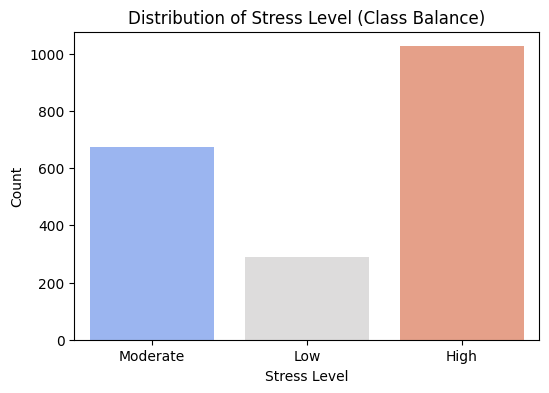


Class distribution (%):
stress_level
High        51.531894
Moderate    33.852336
Low         14.615771
Name: proportion, dtype: float64


In [ ]:
if 'stress_level' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='stress_level', data=df, palette="coolwarm")
    plt.title("Distribution of Stress Level (Class Balance)")
    plt.xlabel("Stress Level")
    plt.ylabel("Count")
    plt.show()

    print("\nClass distribution (%):")
    print(df['stress_level'].value_counts(normalize=True)*100)


**Class Distribution (ไม่สมดุล)**
ข้อมูลนักศึกษามีการกระจายระดับความเครียดไม่เท่ากัน
ส่วนใหญ่เป็น ระดับปานกลางและสูง ต้องแก้ไขเรื่อง class imbalance ก่อนจะนำข้อมูลไปใช้ต่อในอนาคต

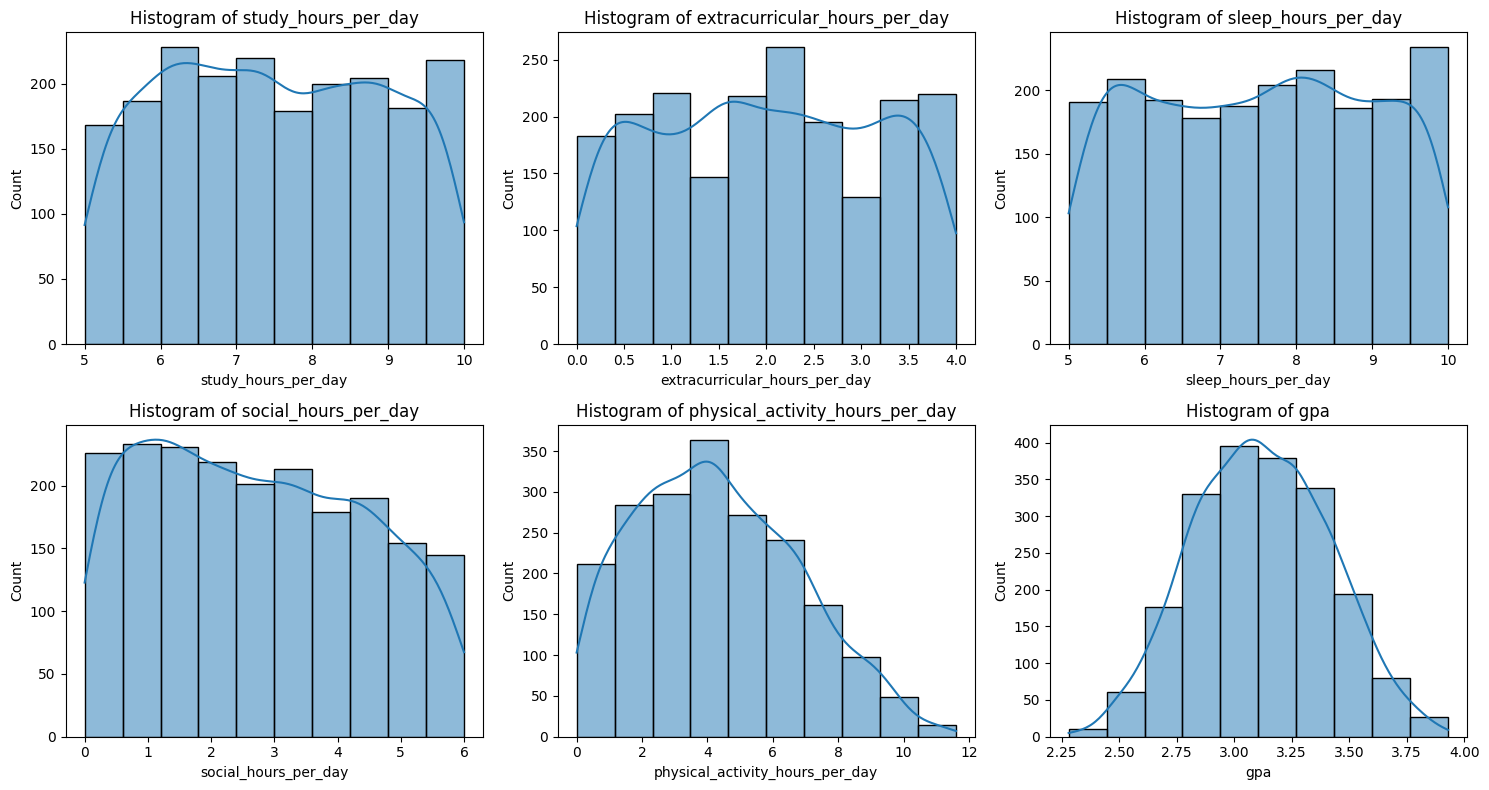

In [ ]:
numeric_cols = [
    'study_hours_per_day',
    'extracurricular_hours_per_day',
    'sleep_hours_per_day',
    'social_hours_per_day',
    'physical_activity_hours_per_day',
    'gpa'
]

rows = 2
cols = 3
plt.figure(figsize=(cols*5, rows*4))  # ปรับขนาดรูป

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], bins=10, kde=True)
    plt.title(f"Histogram of {col}")

plt.tight_layout()  # จัด layout ให้สวย
plt.show()         # แสดงกราฟ

**ภาพ Histogram แสดงการกระจายตัว ของตัวแปรเชิงปริมาณหลายตัว ที่เกี่ยวกับพฤติกรรมประจำวันกับค่า GPA ของนักเรียน**  

**study_hours_per_day**
การกระจายสม่ำเสมอ (5–10 ชม./วัน)
ไม่มีการกระจุกชัดเจน มีนักเรียนที่อ่านหนังสือทั้งช่วงน้อยและมากพอ ๆ กัน

**extracurricular_hours_per_day** ส่วนใหญ่ใช้เวลา 0–4 ชม./วัน กระจายตัวใกล้เคียงกันมากในแต่ละช่วง

**sleep_hours_per_day**
การกระจายสม่ำเสมอ (5–10 ชม./วัน)

**social_hours_per_day**
การกระจายลดลงตามจำนวนชั่วโมง
นักเรียนส่วนใหญ่ใช้เวลา เข้าสังคมน้อยกว่า 2 ชม./วัน
น้อยคนที่จะใช้เวลามากกว่า 5 ชม./วัน

**physical_activity_hours_per_day**
ค่าการกระจายเป็น Right-skewed (เบ้ขวา)
ส่วนใหญ่ใช้เวลา 2–5 ชม./วัน ในกิจกรรมออกกำลังกาย
มีบางคนที่ใช้เวลามากถึง 10–12 ชม./วัน แต่เป็น outlier

**GPA**
การกระจายเป็น Normal distribution (โค้งระฆัง)
ส่วนใหญ่ GPA อยู่ระหว่าง 2.8 – 3.5
ค่ากลาง 3.1

###Bivariate analysis

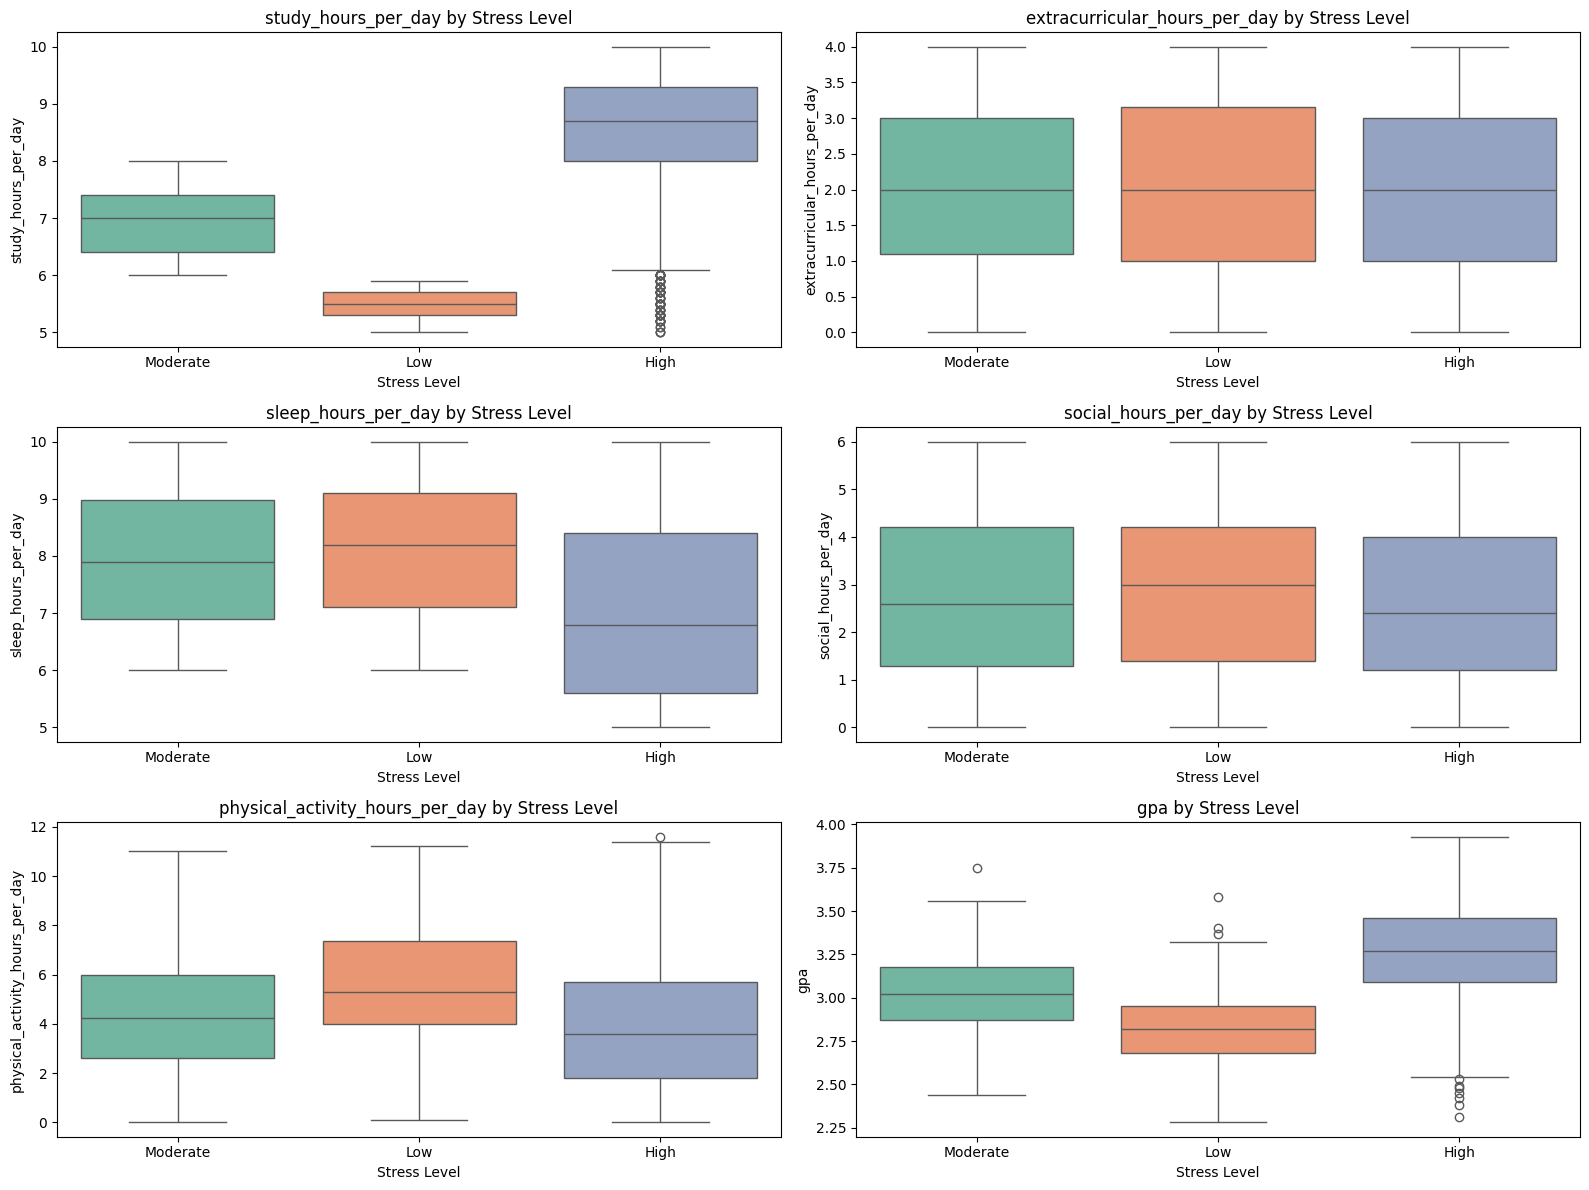

In [ ]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(
        x='stress_level',
        y=col,
        data=df,
        hue='stress_level',   # เพิ่ม hue
        palette='Set2',
        dodge=False,
        legend=False
    )
    plt.title(f'{col} by Stress Level')
    plt.xlabel("Stress Level")
    plt.ylabel(col)

plt.tight_layout()
# plt.savefig("/content/1", dpi=300)
plt.show()

####**วิเคราะห์ feature ตามระดับ Stress_Level ด้วย boxplot**

**1. study_hours_per_day**
High stress กระจายกว้าง บางคนเรียนถึง 9–10 ชั่วโมงและมี outliers ที่อ่านน้อย (5–6 ชั่วโมง) ยิ่งนักศึกษาใช้เวลาเรียนมาก ความเครียดมีแนวโน้มสูงขึ้นอย่างชัดเจน

**2. extracurricular_hours_per_day**  
ทั้งสามกลุ่ม Low / Moderate / High มีค่าใกล้เคียงกัน
ไม่มีความแตกต่างชัดเจน
กิจกรรมเสริมไม่ค่อยเกี่ยวกับระดับความเครียด

**3. sleep_hours_per_day**  
Low stress: นอน 8 ชั่วโมงขึ้นไป   
Moderate stress: นอน 7 ชั่วโมง  
High stress: นอนน้อยกว่า 6 ชั่วโมง
การนอนน้อยสัมพันธ์กับความเครียดสูง

**4. social_hours_per_day**  
ทั้งสามกลุ่มมีค่าคล้ายกัน (2 ชั่วโมง)
ความแตกต่างไม่เด่น
เวลาเข้าสังคมไม่ได้ส่งผลชัดเจนต่อความเครียด

**5. physical_activity_hours_per_day**  
Low stress: ออกกำลังกายเยอะเกิดความเครียดน้อย มี outliers ที่  High stress แต่ค่าของทั้งสามกลุ่มไม่ได้แตกต่างกันมาก ดังนั้นการออกกำลังกายไม่ได้เป็นตัวแยกชัดเจนเรื่องความเครียด

**6. gpa**  
Low stress: GPA ต่ำกว่ากลุ่มอื่น   
Moderate stress: GPA ประมาณ 3.00  
High stress: GPA สูงที่สุด   
กลุ่มที่เครียดสูงมีเกรดสูง สะท้อนว่าแรงกดดันจากการเรียนสัมพันธ์กับการรักษา GPAและอาจทำให้เกิดความเครียด

###Correlation Matrix

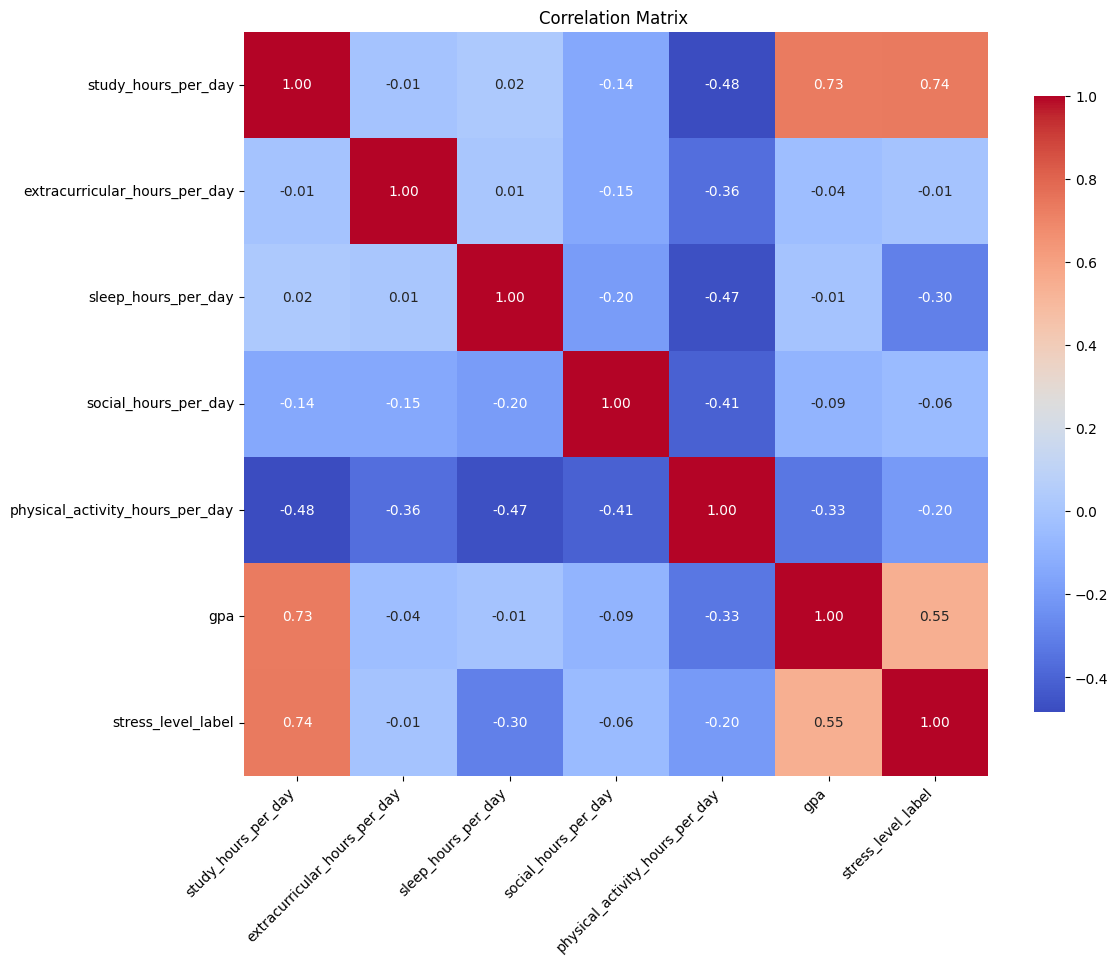

In [ ]:
numeric_cols = [
    'study_hours_per_day',
    'extracurricular_hours_per_day',
    'sleep_hours_per_day',
    'social_hours_per_day',
    'physical_activity_hours_per_day',
    'gpa',
    'stress_level_label'   # เพิ่ม target label เข้าไป
]

# ทำ correlation matrix
corr = df[numeric_cols].corr()

# วาด heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True,
            cbar_kws={"shrink": 0.8})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("Correlation Matrix ")
plt.show()


###**Correlation Matrix วิเคราะห์ความสัมพันธ์ของ Stress Level**  


**study_hours_per_day กับ stress_level** (r = 0.74)  
ความสัมพันธ์ทางบวกสูง
ยิ่งเรียนเยอะต่อวัน = ยิ่งเครียดมาก

**gpa กับ stress_level** (r = 0.55)

ความสัมพันธ์ทางบวกปานกลางถึงสูง
GPA สูง มักเจอระดับความเครียดสูง

**sleep_hours_per_day กับ stress_level** (r = -0.30)  
ความสัมพันธ์ทางลบ
ยิ่งนอนมาก ความเครียดลดลง
การพักผ่อนเพียงพอช่วยลดความเครียดได้

**physical_activity_hours_per_day กับ stress_level** (r = -0.20)

ความสัมพันธ์ทางลบอ่อน ๆ
กิจกรรม/ออกกำลังกายมากขึ้น ความเครียดลดลงเล็กน้อย

**extracurricular_hours_per_day กับ stress_level** (= -0.01)

แทบไม่มีความสัมพันธ์  เวลากิจกรรมเสริมไม่ได้ส่งผลต่อความเครียด

**social_hours_per_day กับ stress_level** (= -0.06)

ความสัมพันธ์ต่ำมาก เวลาเข้าสังคมมีผลน้อยต่อระดับความเครียด

# **INSIGHT**



จากการวิเคราะห์ข้อมูล Student Lifestyle Dataset (หลัง clean เหลือ 1,991 แถว และ 9 คอลัมน์) พบว่า ตัวแปรพฤติกรรมการใช้ชีวิตและผลการเรียนมีผลโดยตรงต่อระดับความเครียดของนักศึกษา (Stress Level) โดยข้อมูลมีการกระจายไม่สมดุล (Class Imbalance) ซึ่งส่วนใหญ่เป็นความเครียดระดับ ปานกลาง–สูง

ปัจจัยสำคัญที่สัมพันธ์กับความเครียด ได้แก่

- Study Hours per Day: ยิ่งเรียนมาก ความเครียดสูงขึ้นอย่างชัดเจน  

- Sleep Hours per Day: นักศึกษาที่นอนน้อย (<6 ชม.) มีแนวโน้มเครียดสูง   ขณะที่การนอน ≥8 ชม. จะมีความเครียด ปลานกลาง-น้อย

- GPA: กลุ่มที่มี GPA สูงมักมีความเครียดสูง และมีความกดดันด้านผลการเรียน  

- Physical Activity และ Social Hours มีผลบ้าง แต่ไม่ชัดเจนเมื่อเทียบกับการเรียน  การนอน และ GPA

**สรุปได้ว่า** การทำนายระดับความเครียดของนักศึกษาสามารถทำได้จาก พฤติกรรมการเรียน  การนอน และผลการเรียน (GPA) เป็นหลัก โดยรูปแบบที่พบบ่อยคือ  

เรียนมาก + GPA สูง + นอนน้อย = ความเครียดสูง  
ขณะที่นักศึกษาที่ นอนเพียงพอ + มีกิจกรรมผ่อนคลาย + GPA ไม่กดดันมาก   มีแนวโน้มเครียดต่ำกว่าอย่างชัดเจน


## **Summary project progress**

**หัวข้อ:** Predicting Student Stress Level from Lifestyle   Behaviors  
**Dataset:** student lifestyle dataset  
**จำนวนแถว:(ก่อน clean )** 2000 rows  
**จำนวนคอลัมน์ (ก่อน clean ) :** 8 columns (Student_ID,Study_Hours_Per_Day,	Extracurricular_Hours_Per_Day,	Sleep_Hours_Per_Day,	Social_Hours_Per_Day,	Physical_Activity_Hours_Per_Day,	GPA,	Stress_Level
)  
**จำนวนแถว: (หลัง clean )** 1991 rows  
**จำนวนคอลัมน์ (หลัง clean ) :** 9 columns (study_hours_per_day,	extracurricular_hours_per_day,	sleep_hours_per_day,	social_hours_per_day,	physical_activity_hours_per_day,	gpa,	stress_level,	stress_level_label,	sleep_bucket)   
**Target Variable:** Stress_Level (Low, Moderate, High)  
**Data Wrangling**
- ทำความสะอาดชื่อคอลัมน์
- ลบคอลัมน์ student_id  
- ตรวจหาค่า outlier ที่คอลัมน์ numeric
- ลบแถวซ้ำ  

**Explore Data Analysis**
- ตรวจสอบข้อมูลที่ clean มาแล้ว
- Descriptiv Statistic: อธิบายลักษณะของข้อมูลเชิงตัวเลขเบื้องต้น และ สรุปเชิงสถิติ (mean & std) ของตัวแปร numeric ตามกลุ่ม Stress Level
- Univariate Analysis:ตรวจสอบ การกระจายตัวของ categorical variable และสร้าง histogram สำหรับแต่ละ numeric feature
- Bivariate analysis: วิเคราะห์ ค่าเฉลี่ยและการกระจายตัวของแต่ละ feature ตามระดับ Stress_Level ด้วย boxplot
- Correlation Matrix: ทำ Heatmap ตรวจสอบ ตัวแปรที่สัมพันธ์กับ target (stress_level_label)
****
**1.Target (Stress_Level) มี class balance หรือไม่?**  
Class Distribution (ไม่สมดุล)
ข้อมูลนักศึกษามีการกระจายระดับความเครียดไม่เท่ากัน
ส่วนใหญ่เป็น ระดับปานกลาง–สูง ต้องระวังเรื่อง class imbalance  
**2.วิเคราะห์ว่าค่าเฉลี่ย/การกระจายตัวของแต่ละ feature แตกต่างกันอย่างไรตามระดับ Stress_Level**  
- study_hours_per_day: ยิ่งเรียนมาก ความเครียดสูง กระจายกว้าง มี outliers ที่เรียนต่ำ (5–6 ชม.)  
- extracurricular_hours_per_day: ค่าใกล้เคียงกันทั้งกลุ่ม กิจกรรมเสริมไม่สัมพันธ์กับความเครียด  
- sleep_hours_per_day: นอนน้อย = ความเครียดสูง Low stress นอน ≥8 ชม., Moderate 7 ชม.และ High <6 ชม.  
- social_hours_per_day: ค่าใกล้เคียงกัน (2 ชม.) ไม่แตกต่างชัดเจน  
- physical_activity_hours_per_day: Low stress ออกกำลังกายมากบ้าง แต่ไม่แตกต่างชัดเจน กลุ่ม High มี outliers  
- gpa: กลุ่ม High stress มี GPA สูงสุด, Moderate 3.0, Low ต่ำสุด = แรงกดดันจาก GPA สัมพันธ์กับความเครียด  

**3.มี Missing Values หรือค่าผิดปกติไหม?**  
หลังจากนำข้อมูลที่ clean แล้วมาวิเคราะห์ พบว่าในบาง column เกิด outlier ในการนำไปทำต่อยอดโมเดล อาจต้องพิจารณาข้อมูลอีกครั้ง  
**4.Feature ใดที่สำคัญต่อการทำนาย Stress Level?**  
- การเรียนเยอะ เกิดความเครียดสูง (study_hours_per_day )
- GPA สูง มีความเครียดสูง(GPA)
- การนอนเยอะ มีความเครียดต่ำ (sleep_hours_per_day )
- การออกกำลังกาย/ทำกิจกรรม มีความเครียดต่ำ (physical_activity_hours_per_day )   
****
ดังนั้น
การคาดการณ์ระดับความเครียดของนักศึกษา (Stress Level) สามารถทำได้จากข้อมูลพฤติกรรมด้านการเรียน การนอน และผลการเรียน (GPA) ซึ่งเป็น
ปัจจัยที่ส่งผลต่อความเครียดอย่างเห็นได้ชัดที่สุด เช่น เรียนเยอะ + GPA สูง + นอนน้อย = เกิดความเครียดสูง


#Part 2

เลือก Features และ Target จากชุดข้อมูล โดยมีรายละเอียดดังนี้:

**Features (X)**

* study_hours_per_day – ชั่วโมงการเรียนต่อวัน

* extracurricular_hours_per_day – ชั่วโมงทำกิจกรรมเสริม

* sleep_hours_per_day – ชั่วโมงการนอน

* social_hours_per_day – ชั่วโมงเข้าสังคม

* physical_activity_hours_per_day – ชั่วโมงออกกำลังกาย

* gpa – เกรดเฉลี่ย

**Target (y)**

* stress_level_label – ระดับความเครียดที่ต้องการทำนาย

##KNN Model

### **Data pre-processing** (KNN Models)

In [ ]:
# เลือก Features และ Target
X = df[[
    "study_hours_per_day",
    "extracurricular_hours_per_day",
    "sleep_hours_per_day",
    "social_hours_per_day",
    "physical_activity_hours_per_day",
    "gpa"
]]

y = df["stress_level_label"]

# แบ่งข้อมูล Train/Test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
# Standardization (Scaling)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### **Build Machine Learning Model**

In [ ]:
# สร้าง Model

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Model name : **K-Nearest Neighbors (KNN)**

###Evaluate Model

หลังจากทำการเทรนโมเดล KNN แล้ว ได้ทำการทำนายค่าจากชุดทดสอบ (X_test_scaled) และตรวจสอบความแม่นยำ

In [ ]:
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9197994987468672
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        58
           1       0.91      0.85      0.88       135
           2       0.94      0.98      0.96       206

    accuracy                           0.92       399
   macro avg       0.91      0.90      0.90       399
weighted avg       0.92      0.92      0.92       399



หาโมเดล KNN ที่ดีที่สุด ได้ใช้ GridSearchCV เพื่อทดสอบหลายๆ ชุดค่าพารามิเตอร์

In [ ]:
# Hyperparameter Tuning
params = {
    "n_neighbors": [3,5,7,9,11,13,15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("=== Best Params ===")
print(grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


=== Best Params ===
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best CV Accuracy: 0.9145896177125845


In [ ]:
results = pd.DataFrame(grid.cv_results_)

# แยกสำหรับ weights = 'uniform'
pivot_uni = results[results['param_weights'] == 'uniform'].pivot_table(
    index='param_n_neighbors',
    columns='param_metric',
    values='mean_test_score'
)

# แยกสำหรับ weights = 'distance'
pivot_dis = results[results['param_weights'] == 'distance'].pivot_table(
    index='param_n_neighbors',
    columns='param_metric',
    values='mean_test_score'
)

print("=== Pivot (uniform) ===")
print(pivot_uni)
print("\n=== Pivot (distance) ===")
print(pivot_dis)


=== Pivot (uniform) ===
param_metric       euclidean  manhattan
param_n_neighbors                      
3                   0.883183   0.890716
5                   0.881278   0.901390
7                   0.886323   0.901396
9                   0.883802   0.908937
11                  0.889464   0.913963
13                  0.891980   0.906421
15                  0.891355   0.910191

=== Pivot (distance) ===
param_metric       euclidean  manhattan
param_n_neighbors                      
3                   0.881294   0.891347
5                   0.884423   0.902025
7                   0.890095   0.905792
9                   0.893226   0.911451
11                  0.896368   0.914590
13                  0.897005   0.910822
15                  0.898257   0.913961


หลังจากทำการปรับ Hyperparameters แล้ว ได้เลือกโมเดลที่ดีที่สุด เพื่อนำมาทดสอบบน Test Set

โมเดลที่ได้จาก Grid Search คือ

* metric = manhattan

* n_neighbors = 11

* weights = distance

####classification report

In [ ]:
# ใช้โมเดลที่ดีที่สุดมาทดสอบบน Test Set

best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test_scaled)

print("=== Test Result with Best Model ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


=== Test Result with Best Model ===
Accuracy: 0.9548872180451128
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        58
           1       0.95      0.92      0.94       135
           2       0.95      0.99      0.97       206

    accuracy                           0.95       399
   macro avg       0.96      0.94      0.95       399
weighted avg       0.95      0.95      0.95       399



โมเดลแยกระดับความเครียดได้ดีมากในทั้ง 3 คลาส

มีความแม่นยำสูง (95.49%)

Recall ของคลาส High สูงถึง 0.99 (สำคัญเพราะเป็นกลุ่มเสี่ยง)

โมเดลมีโอกาสสลับทำนายระหว่างคลาส Low ↔ Moderate บ้าง
(เพราะสองคลาสนี้มักมีพฤติกรรมใกล้เคียงกัน) แต่ยังคงแม่นยำสูง

ไม่มีคลาสใดที่โมเดลทำนายผิดพลาดหนัก

#### Confusion matrix

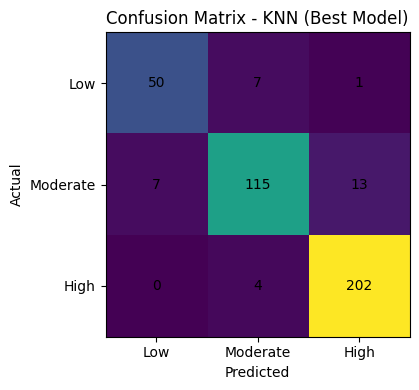

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix - KNN (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

classes = ["Low","Moderate","High"]
plt.xticks([0,1,2], classes)
plt.yticks([0,1,2], classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.show()

โมเดล KNN สามารถทำนายระดับความเครียดได้ดีมาก

Confusion Matrix

จากภาพ:

Low → ทายถูก 50 จาก 58

Moderate → ทายถูก 115 จาก 135

High → ทายถูก 202 จาก 206

ภาพรวมถือว่าดี แต่ยังมี moderate ผิดเป็น high บ้าง

หลังการปรับ Hyperparameter ความแม่นยำเพิ่มขึ้นเป็น 95.49%

โมเดลทำงานได้ยอดเยี่ยมในทุกคลาส โดยเฉพาะคลาส High

##Naive Bayes Model

### **Data pre-processing** (Naive Bayes)

In [ ]:
X = df[[
    "study_hours_per_day",
    "extracurricular_hours_per_day",
    "sleep_hours_per_day",
    "social_hours_per_day",
    "physical_activity_hours_per_day",
    "gpa"
]]

y = df["stress_level_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

###**Build Machine Learning Model**

In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)


GaussianNB()

Model name : **Navie Bayes**


###Evaluate Model

####classification report No Scaling



In [ ]:
# Without Scaling
y_pred_nb_noscale = nb_model.predict(X_test)

print("=== Naive Bayes (GaussianNB) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb_noscale))
print(classification_report(y_test, y_pred_nb_noscale, zero_division=0))

=== Naive Bayes (GaussianNB) ===
Accuracy: 0.5162907268170426
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.00      0.00      0.00       135
           2       0.52      1.00      0.68       206

    accuracy                           0.52       399
   macro avg       0.17      0.33      0.23       399
weighted avg       0.27      0.52      0.35       399



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


ผลการประเมิน Gaussian Naive Bayes แบบไม่ทำ Scaling พบว่าโมเดลมีประสิทธิภาพต่ำ โดยให้ Accuracy เพียง 51.63% เท่านั้น และไม่สามารถจำแนกคลาส Low และ Moderate ได้เลย (ค่า Precision และ Recall เท่ากับ 0) เนื่องจากโมเดลทำนายตัวอย่างทั้งหมดเป็นคลาส High ซึ่งมีจำนวนมากที่สุดในข้อมูล ทำให้เกิด class bias อย่างรุนแรง สาเหตุเกิดจากข้อมูลที่ไม่เป็น Gaussian distribution และความแตกต่างของสเกลแต่ละ feature ทำให้ GaussianNB คำนวณค่าความน่าจะเป็นผิดพลาด ส่งผลให้โมเดลไม่สามารถแยกคลาสได้ถูกต้อง

####classification report Scaling



In [ ]:
# With Scaling
y_pred_nb_scaled = nb_model.predict(X_test_scaled)

print("=== Naive Bayes (GaussianNB + scaled) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_nb_scaled))
print(classification_report(y_test, y_pred_nb_scaled, zero_division=0))

=== Naive Bayes (GaussianNB + scaled) ===
Accuracy: 0.8771929824561403
              precision    recall  f1-score   support

           0       0.79      1.00      0.89        58
           1       0.88      0.84      0.86       135
           2       0.90      0.87      0.89       206

    accuracy                           0.88       399
   macro avg       0.86      0.90      0.88       399
weighted avg       0.88      0.88      0.88       399



หลังจากทำการปรับสเกลข้อมูลด้วย StandardScaler ก่อนนำไปฝึกโมเดล Gaussian Naive Bayes พบว่า Accuracy เพิ่มขึ้นจาก 51.63% เป็น 87.72% นอกจากนี้ค่า Precision, Recall และ F1-score ของทุกคลาสมีค่าสูงขึ้นอย่างมีนัยสำคัญ โดยเฉพาะคลาส Low ที่สามารถทำนายได้ถูกต้องครบทุกตัว (Recall = 1.00) และคลาส Moderate และ High ก็ยังคงมีค่าความแม่นยำสูง (F1-score 0.86–0.89) ทำให้ GaussianNB เป็นโมเดลที่ให้ผลลัพธ์ดีเมื่อทำการ Scaling ก่อนฝึกโมเดล

####Confusion Matrix No Scaling

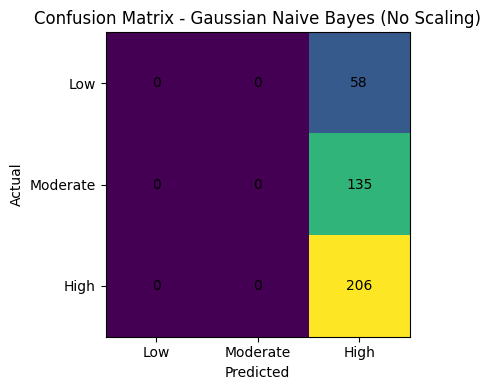

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb_noscale)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix - Gaussian Naive Bayes (No Scaling)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

classes = ["Low", "Moderate", "High"]
plt.xticks([0, 1, 2], classes)
plt.yticks([0, 1, 2], classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

Gaussian Naive Bayes (ไม่ทำ Scaling)  

โมเดลไม่สามารถทำนายคลาส Low และ Moderate ได้เลย (precision=0, recall=0)

ทำนายทุกอย่างเป็น High เพราะ High มีจำนวนมากที่สุด → โมเดลเกิด class bias

ประสิทธิภาพโดยรวมต่ำมาก

ไม่เหมาะกับงานนี้ในรูปแบบไม่ scaled

####Confusion Matrix Scaling

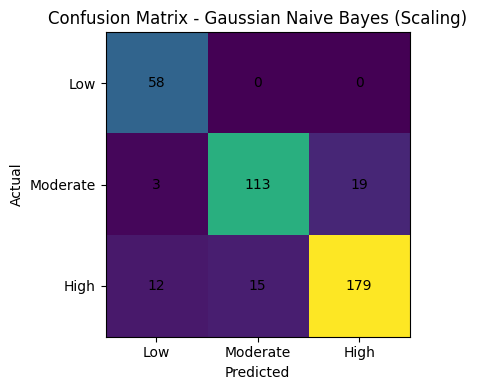

In [ ]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb_scaled)

plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix - Gaussian Naive Bayes (Scaling)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

classes = ["Low", "Moderate", "High"]
plt.xticks([0, 1, 2], classes)
plt.yticks([0, 1, 2], classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

Gaussian Naive Bayes (ใช้ Scaling – StandardScaler)

ประสิทธิภาพดีขึ้นแบบก้าวกระโดด หลังการ scaling

คลาส Low ถูกทำนายได้สมบูรณ์แบบ

โมเดลเริ่มแยก Moderate และ High ได้ดีขึ้น

ยังไม่แม่นเท่า KNN แต่ถือว่าดีมากสำหรับ Naive Bayes

##Linear Regression Model

### **Data pre-processing** (Linear Regression) ทำนาย Stress Level แบบตัวเลข

In [ ]:
X = df[[
    "study_hours_per_day",
    "extracurricular_hours_per_day",
    "sleep_hours_per_day",
    "social_hours_per_day",
    "physical_activity_hours_per_day",
    "gpa"
]]
y = df["stress_level_label"].astype(float)   # ให้แน่ใจว่าเป็นตัวเลข

# แบ่ง Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Build Machine Learning Models

In [ ]:
# สร้างโมเดล Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict
y_pred = lr.predict(X_test_scaled)

Models Name : **Linear Regression**

###Evaluate Model

####MSE and R² Score

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("=== Linear Regression (Predict Numeric Stress Level) ===")
print("MSE :", mse)
print("R² Score:", r2)

=== Linear Regression (Predict Numeric Stress Level) ===
MSE : 0.1744344943746903
R² Score: 0.6671523403616709


MSE = 0.174 ถือว่าต่ำ เมื่อเทียบกับค่าระดับความเครียด (0–2) แสดงว่าโมเดลทำนายได้ใกล้เคียงกับค่าจริงได้ดี

R² = 0.667 หมายความว่าโมเดลอธิบายความแปรปรวนของระดับความเครียดได้ 66.7% ถือว่าค่อนข้างดี แต่ยังมี 33.3% ที่โมเดลยังอธิบายไม่ได้

####Scatter Plot
แสดงความสัมพันธ์ระหว่าง 'Actual Stress Level' (ระดับความเครียดจริง) กับ 'Predicted Stress Level' (ระดับความเครียดที่ทำนาย)

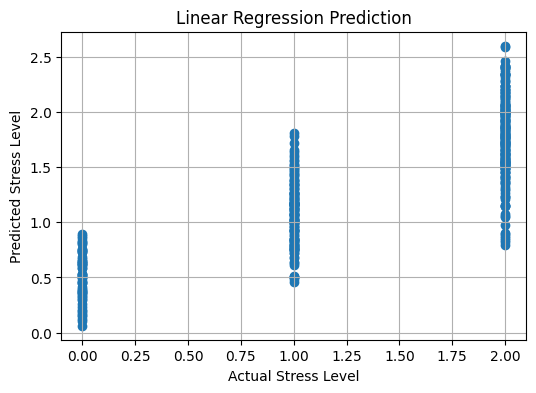

In [ ]:
# Scatter Plot
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Stress Level")
plt.ylabel("Predicted Stress Level")
plt.title("Linear Regression Prediction")
plt.grid(True)
plt.show()

กราฟกระจายที่แสดงความสัมพันธ์ระหว่าง 'Actual Stress Level' (ระดับความเครียดจริง) กับ 'Predicted Stress Level' (ระดับความเครียดที่ทำนาย)   
ข้อมูลถูกจัดเป็น 3 กลุ่มแนวดิ่งตามค่า stress จริง คือ 0, 1, 2

แต่ค่าที่โมเดลทำนายเป็นค่าเชิงต่อเนื่อง (0.1–2.6)
ซึ่งเป็นลักษณะปกติของ Linear Regression เพราะมันให้ค่าเป็นตัวเลขต่อเนื่อง ไม่ใช่คลาส

การกระจายของจุดในแต่ละกลุ่ม

กลุ่ม Actual = 0: โมเดลให้ค่าทำนายระหว่างประมาณ 0.1–0.9

กลุ่ม Actual = 1: ค่าทำนายอยู่ประมาณ 0.5–1.8

กลุ่ม Actual = 2: ค่าทำนายอยู่ประมาณ 0.9–2.6

การกระจายแบบนี้บ่งบอกว่า:

โมเดล “พอจับแนวโน้มได้” ว่าค่า stress สูง → ทำนายสูงขึ้น

แต่มี ความซ้อนทับระหว่างคลาส (overlap) ค่อนข้างเยอะ ทำให้มีข้อจำกัดในการทำนายค่าระดับความเครียดที่เป็นหมวดหมู่ โดยเฉพาะในกลุ่ม 'Low' ที่โมเดลอาจจะทำนายไปทาง 'Moderate' มาก


#### Linear Regression → แปลงผลเป็นคลาส (Classification)

=== Linear Regression Converted to Classification ===
Accuracy: 0.7819548872180451
              precision    recall  f1-score   support

         0.0       0.93      0.47      0.62        58
         1.0       0.62      0.90      0.74       135
         2.0       0.93      0.80      0.86       206

    accuracy                           0.78       399
   macro avg       0.83      0.72      0.74       399
weighted avg       0.83      0.78      0.78       399



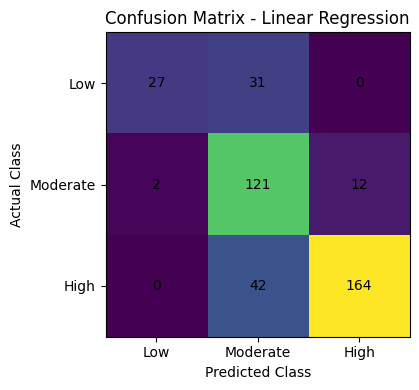

In [ ]:
# ตัดค่าผลลัพธ์ให้เป็น 0/1/2
y_pred_class = np.clip(np.round(y_pred), 0, 2).astype(int)

print("=== Linear Regression Converted to Classification ===")
print("Accuracy:", accuracy_score(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class, zero_division=0))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix - Linear Regression")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

classes = ["Low","Moderate","High"]
plt.xticks([0,1,2], classes)
plt.yticks([0,1,2], classes)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.show()


Linear Regression เมื่อนำมาแปลงเป็นคลาสให้ผล accuracy 0.78ถือว่าอยู่ในระดับ ปานกลางค่อนดี สำหรับข้อมูล 3 คลาส (Low / Moderate / High)
มักทำนายคลาส High ได้ดี แต่สับสนระหว่าง Low กับ Moderate
เพราะค่าที่โมเดลทำนายเป็นตัวเลขต่อเนื่องและช่วงของแต่ละคลาสซ้อนทับกันมาก

## **Summary**

###สรุปการทำงานของโมเดล
---  

**วิธีการแก้ปัญหา:**

- ใช้ชุดข้อมูลพฤติกรรมของนักศึกษา เช่น ชั่วโมงการนอน, ชั่วโมงการเรียนต่อวัน, ชั่วโมงกิจกรรมสังคม และ GPA

- ทำการทดลองสร้างโมเดลหลายแบบ ได้แก่ KNN, Gaussian Naive Bayes, Linear Regression

- สำหรับ Gaussian Naive Bayes มีการทดลองทั้งแบบไม่ทำ Scaling และทำ Scaling (StandardScaler) เพื่อดูผลกระทบของการปรับขนาดข้อมูล

**ผลการทดลองของโมเดล:**

**KNN (K-Nearest Neighbors)**

- สามารถทำนายระดับความเครียดได้ดีมาก
Accuracy: 95.49%

- Confusion Matrix แสดงให้เห็นว่าโมเดลสามารถทำนายคลาส Low, Moderate, High ได้แม่นยำ โดยเฉพาะคลาส High

- หลังปรับ Hyperparameter, โมเดลมีประสิทธิภาพสูงสุดสำหรับทุกคลาส

**Gaussian Naive Bayes**

- **ไม่ทำ Scaling**: Accuracy ต่ำมาก 51.63%

-  ทำนายทุกตัวอย่างเป็นคลาส High → เกิด class bias ไม่สามารถทำนายคลาส Low และ Moderate ได้เลย

- **ทำ Scaling** (StandardScaler): Accuracy เพิ่มขึ้นเป็น 87.72%

- สามารถทำนายคลาส Low ถูกต้องทั้งหมด (Recall=1.0)

- Moderate และ High มีค่า Precision, Recall, F1-score สูงขึ้นอย่างมีนัยสำคัญ
แสดงให้เห็นว่า การปรับสเกลข้อมูลช่วยลด class bias และเพิ่มประสิทธิภาพของ GaussianNB

**Linear Regression (ใช้ทำนายค่า numeric stress level)**

- MSE: 0.174

- เมื่อแปลงเป็น Classification: Accuracy = 78.2%
สามารถทำนายคลาส High ได้ดี แต่คลาส Low และ Moderate มีค่า Recall และ Precision แตกต่างกัน

- R² Score = 0.667 → โมเดลอธิบายความแปรปรวนของความเครียดได้ประมาณ 66.7%

**สรุปผลการทดสอบ:**

- **KNN** เป็นโมเดลที่ดีที่สุดสำหรับการทำนายระดับความเครียดด้วยข้อมูลเชิงพฤติกรรม
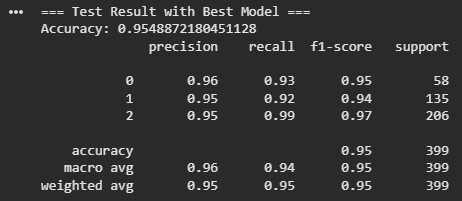  
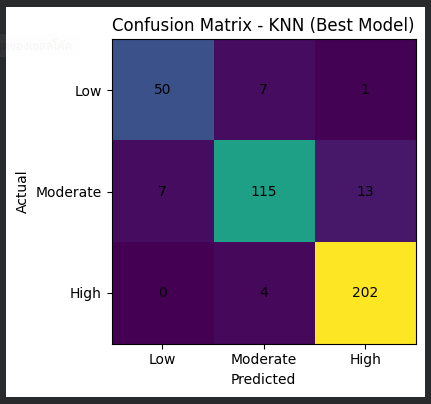

- **Gaussian Naive Bayes** ต้องปรับ Scaling ก่อนจึงจะมีประสิทธิภาพสูง   

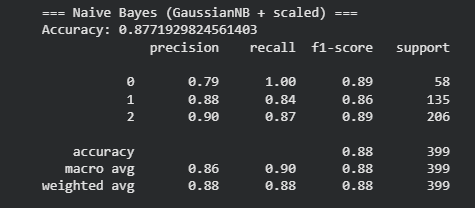  
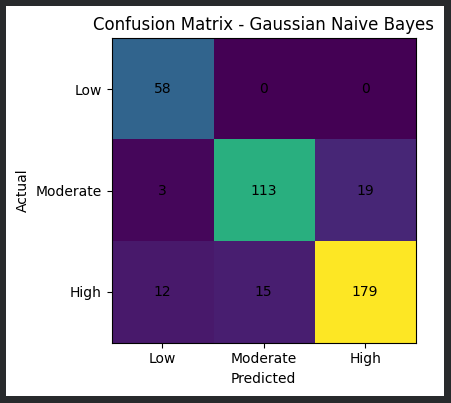

- **Linear Regression** สามารถใช้ทำนาย numeric stress level ได้ แต่แม่นยำต่ำกว่า KNN ซึ่งในงานนี้เป็นการทำนายแบบ Classification Modelนี้จึงอาจยังไม่ตอบโจทย์เท่า KNN และ Naive Bayest

- ปัจจัยหลายอย่าง เช่น ชั่วโมงการนอน, ชั่วโมงเรียน, กิจกรรมสังคม มีผลต่อความเครียด → โมเดลสามารถเรียนรู้ความสัมพันธ์นี้เพื่อทำนายความเครียดได้

- การปรับ Hyperparameter และ Scaling มีผลต่อความแม่นยำของโมเดลอย่างชัดเจน

###สรุปถึงการแก้ปัญหาที่ได้ตั้งไว้
---
**ปัญหาที่ต้องการแก้ไข:**

ปัญหาที่ต้องการให้โมเดลช่วยแก้ไข

1. จากข้อมูลพฤติกรรมการใช้ชีวิตของนักศึกษา (เช่น ชั่วโมงเรียนต่อวัน ชั่วโมงนอน การออกกำลังกาย การใช้มือถือ ฯลฯ) ต้องการทำนาย ระดับความเครียด ของนักศึกษาได้แม่นยำเพียงใด

2. เปรียบเทียบโมเดลหลายแบบ เพื่อหาว่า โมเดลใดให้ประสิทธิภาพดีที่สุด และเหมาะสมสำหรับการวางแผนดูแลสุขภาพจิตนักศึกษา


**สรุปการแก้ปัญหาที่ตั้งไว้**

1. KNN เป็นโมเดลที่ดีที่สุด สำหรับการทำนายระดับความเครียดแบบ Classificationทำให้ตอบโจทย์การสร้างระบบทำนายความเครียดจากข้อมูลเชิงพฤติกรรม

2. GNB หลังทำ Scaling มีประสิทธิภาพดี แต่ยังต่ำกว่า KNN

3. Linear Regression เหมาะสำหรับทำนายค่าตัวเลขของความเครียด แต่ Accuracy สำหรับ Classification ยังไม่สูง

จากผลลัพธ์ชี้ชัดว่าข้อมูลเชิงพฤติกรรมสามารถนำไปสร้างโมเดลเพื่อทำนายระดับความเครียดของนักศึกษาได้อย่างมีประสิทธิภาพ และโมเดลสามารถนำไปใช้วางแผนดูแลสุขภาพจิตนักศึกษาได้ โดยเฉพาะ KNN ที่แม่นยำสูงและทำนายทุกคลาสได้ครบ


